# QLSC 600 : Early warning signals notebook

The objectives of this notebooks are:
- Run a stochatic simulation of a simple ecological model
- Compute early warning signals (EWS) prior to the transition
- Quantify the performance of the EWS using the Kendall Tau statistic

## Import Python packages

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

## Define model

We use the Ricker model with a harvesting term and additive white noise. It is given by
$$ N_{t+1} = N_t e^{(r(1-N_t/K)} ) - f\frac{N_t^2}{N_t^2 + h^2} + \sigma\epsilon_t$$
where $N_t$ is the population size at time $t$, $r$ is the intrinsic growth rate, $K$ is the carrying capacity, $F$ is the maximum rate of harvesting, $h$ is the half saturation constant of the harvesting term, $\sigma$ is the noise amplitude, and $\epsilon_t$ is a normal random variable with zero mean and unit variance.

**Set simulation parameters**

In [28]:
tmax = 1000 # number of time steps
tburn = 100 # time steps for burn-in period to remove transient dynamics
seed = 1 # random number generation seed (set for reproducibility)
np.random.seed(seed)

**Define the function to iterate the model one time step**<br>
We will set default parameters.

In [29]:
def iterate(x, r=0.75, k=10, f=0, h=0.75, sigma=0.1):
    return x*np.exp(r*(1-x/k)) - f*x**2/(x**2+h**2) + sigma*np.random.normal()

## Simulation at default parameters

In [30]:
# Initialise arrays for time and state values
t = np.arange(0,tmax)
x = np.zeros(len(t))

# Run burn-in period starting from intiial condition x0
x0 = 0.8
for i in range(int(tburn)):
    x0 = iterate(x0)

# State value post burn-in period. Set as starting value.
x[0]=x0

# Run simulation
for i in range(len(t)-1):
    x[i+1] = iterate(x[i])
    # If variable drops below zero, reset to zero (model is invalid for x<0)
    if x[i+1] < 0:
        x[i+1] = 0

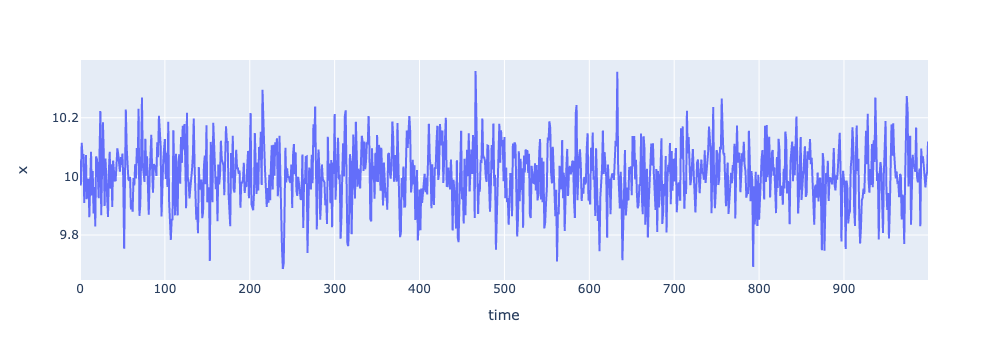

In [31]:
# Make plot
df = pd.DataFrame({'x':x, 'time':t}) # put data in pandas dataframe first
fig = px.line(df, x='time', y='x')
fig.show()

## Exercise - gradual variation of a parameter over time
Run a simulation where the harvesting rate (f) increases from 0 to 3 over time. You can use `np.linspace` to create an array of specified length with linearly increasing values. Make sure to use the appropriate value for f when iterating.

What do you notice?

## Solution (keep hidden until stuck)

In [6]:
# Initialise arrays for time and state values
t = np.arange(0,tmax)
x = np.zeros(len(t))

# Linearly increasing f
flow = 0
fhigh = 3
f = np.linspace(flow, fhigh, len(t))

# Run burn-in period - use initial value of f
x0 = 0.8
for i in range(int(tburn)):
    x0 = iterate(x0, f=f[0])

# State value post burn-in period. Set as starting value.
x[0]=x0

# Run simulation - make sure to use appropriate value for f
for i in range(len(t)-1):
    x[i+1] = iterate(x[i], f=f[i])
    # If variable drops below zero, reset to zero (model is invalid for x<0)
    if x[i+1] < 0:
        x[i+1] = 0

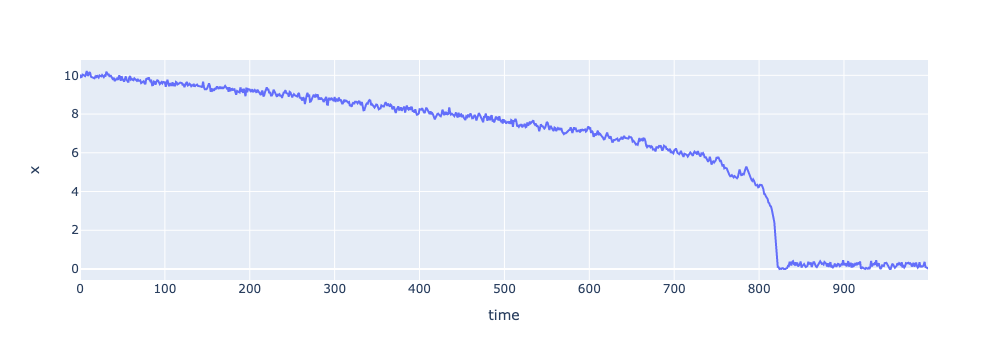

In [7]:
# Make plot
df = pd.DataFrame({'x':x, 'time':t}) # put data in pandas dataframe first
fig = px.line(df, x='time', y='x')
fig.show()

## Computing EWS
EWS are designed to be obtained from detrended data - we are interested in the fluctuations of the system about its equilibrium. There are many approaches to detrending data. Here, we will use the simplest, which is to use a moving average to obtain the trend.

**Work with data prior to the transition**

In [8]:
t_transition = 800 # eye-balled transition time
df_pre = df[df['time']<=t_transition].copy() # time series prior to transition
fig = px.line(df_pre, x='time', y='x')
fig.show()

**Compute the moving average of the signal**

To capture the trend in the data, we will compute the moving average over a rolling window. This can be achieved with [pandas.DataFrame.rolling
](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html).

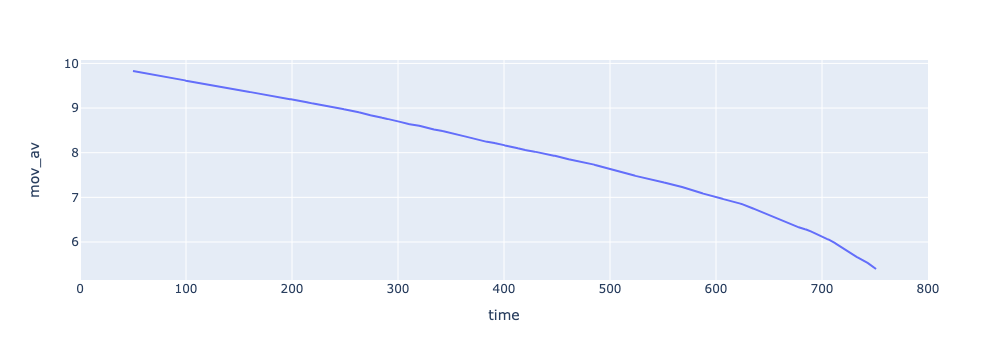

In [9]:
win_mv = 100
df_pre['mov_av'] = df_pre['x'].rolling(window=win_mv, center=True).mean()
fig = px.line(df_pre, x='time', y='mov_av')
fig.show()

**Compute the residuals**<br>
The residuals come from the trend subtracted from the raw signal.

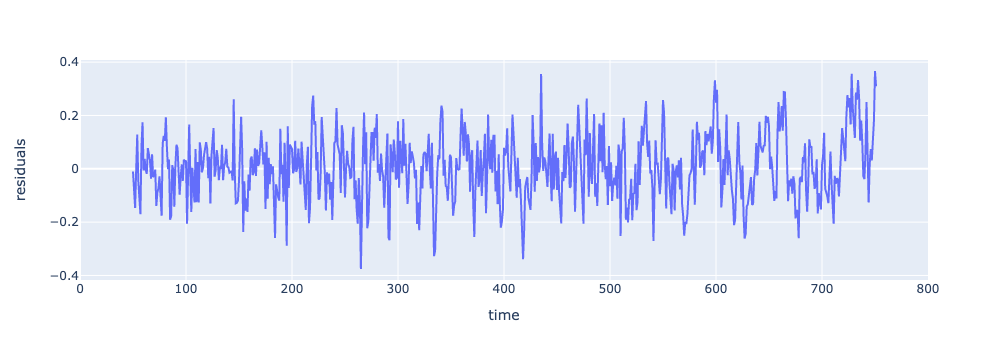

In [10]:
df_pre['residuals'] = df_pre['x'] - df_pre['mov_av']
fig = px.line(df_pre, x='time', y='residuals')
fig.show()

**Compute statistical metrics that can serve as EWS**<br>
Here we will compute the variance and the autocorrelation - again over a rolling window. 

Using [panads.Series.autocorr](https://pandas.pydata.org/docs/reference/api/pandas.Series.autocorr.html)

In [11]:
win_ews = 200

In [12]:
df_pre['variance'] = df_pre['residuals'].rolling(window=win_ews).var()
df_pre['lag1-ac'] = df_pre['residuals'].rolling(window=win_ews).apply(lambda x: x.autocorr(lag=1))

In [13]:
df_pre.head()

x  time  mov_av  residuals  variance  lag1-ac
0  10.036648     0     NaN        NaN       NaN      NaN
1   9.900469     1     NaN        NaN       NaN      NaN
2   9.917762     2     NaN        NaN       NaN      NaN
3  10.037560     3     NaN        NaN       NaN      NaN
4  10.018728     4     NaN        NaN       NaN      NaN

**Make a plot of all the data**

In [14]:
# Organise data into correct form for plotly
df_plot = df_pre.melt(id_vars='time', value_vars=['x','mov_av', 'residuals', 'variance', 'lag1-ac'])
df_plot.head()

time variable      value
0     0        x  10.036648
1     1        x   9.900469
2     2        x   9.917762
3     3        x  10.037560
4     4        x  10.018728

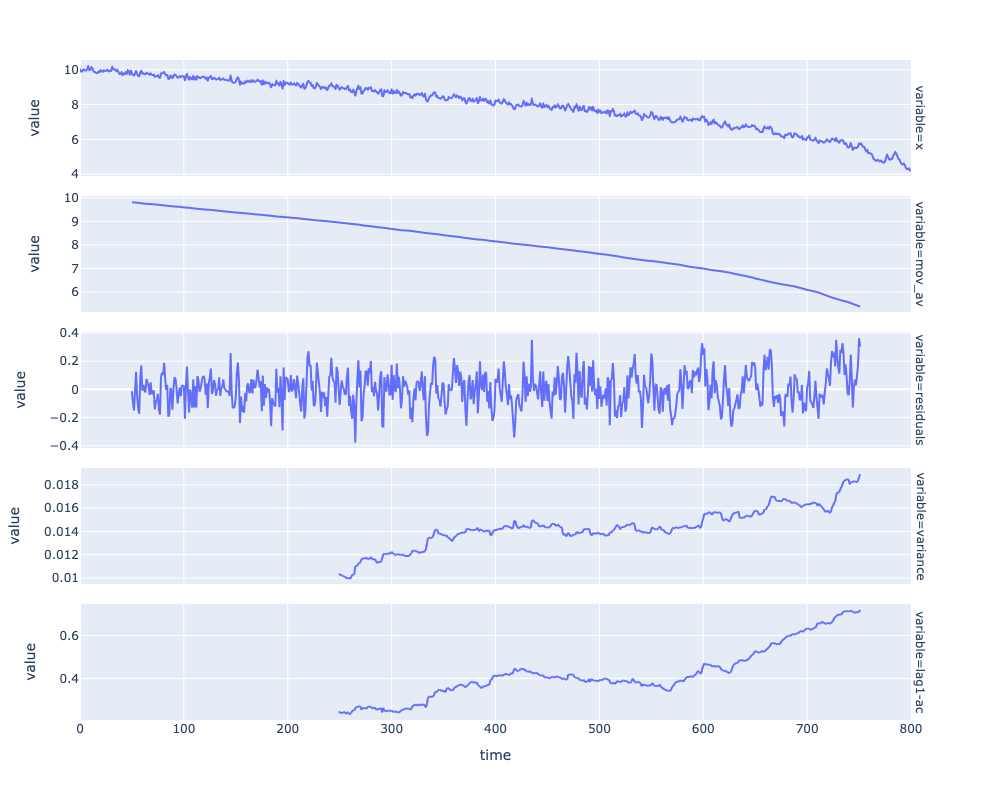

In [15]:
# Make fig
fig = px.line(df_plot, x='time', y='value', facet_row='variable', height=800)
fig.update_yaxes(matches=None)
fig.show()

## Quantifying performance with Kendall tau
The [Kendall tau coefficient](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient) provides a measure of the extent to which the EWS metric is increasing or decreasing with time. It is bounded between 1 and -1. A Kendall tau coefficient of 1 would mean that, for any data point, every subsequent data point has a higher value.

In [16]:
df_pre.dropna()[['time','variance']].corr(method='kendall')

time  variance
time      1.000000  0.733107
variance  0.733107  1.000000

In [17]:
df_pre.dropna()[['time','lag1-ac']].corr(method='kendall')

time   lag1-ac
time     1.000000  0.703833
lag1-ac  0.703833  1.000000

## Exercises
Create a copy of this notebook and try out the following:
- How robust are the EWS to different noise amplitudes (sigma)?
- How robust are they to different time series lengths (tmax)?
- How robust are they to different rolling window lengths (win_ews)?

## A Python package for computing EWS

If you'd like to dig deeper into EWS, there is a Python package written for computing a wide variety of EWS called [ewstools](https://pypi.org/project/ewstools/). To use it, you would need to install it into your environment by entering the following commands into your terminal
```
pip install --upgrade pip
pip install ewstools
```

Tutorials and documentation can be obtained from the [Github repository](https://github.com/ThomasMBury/ewstools). Below, we will use the package to compute EWS in our simulation. 

In [18]:
import ewstools as ewstools

In [19]:
# Set up TimeSeries object (native to ewstools)
ts = ewstools.TimeSeries(data=df['x'], transition=800)

In [20]:
# Detrend the data - we will use a Lowess filter here.
ts.detrend(method='Lowess', span=0.2)

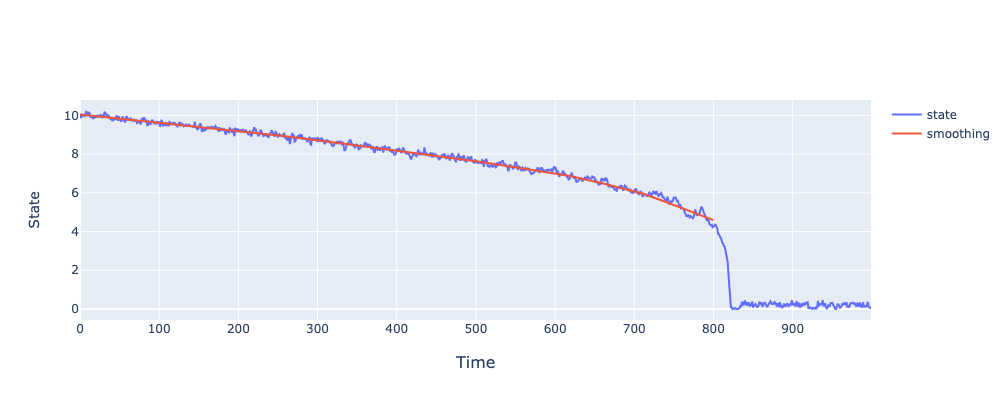

In [21]:
# Check detrending
ts.make_plotly().update_layout(height=400)

In [22]:
# Compute EWS
rw = 0.2 # Define length of rolling window as proportion of lenght of time series
ts.compute_var(rolling_window=rw) # compute variance
ts.compute_auto(rolling_window=rw ,lag=1) # compute lag-1 autocorrelation
ts.compute_auto(rolling_window=rw ,lag=2) # compute lag-2 autocorrelation
ts.compute_skew(rolling_window=rw) # compute skew
ts.compute_spectrum(rolling_window=rw) # compute power spectrum
ts.compute_smax() # compute maximum value of power spectrum
#......etc.

In [23]:
# Compute Kendall tau values
ts.compute_ktau()

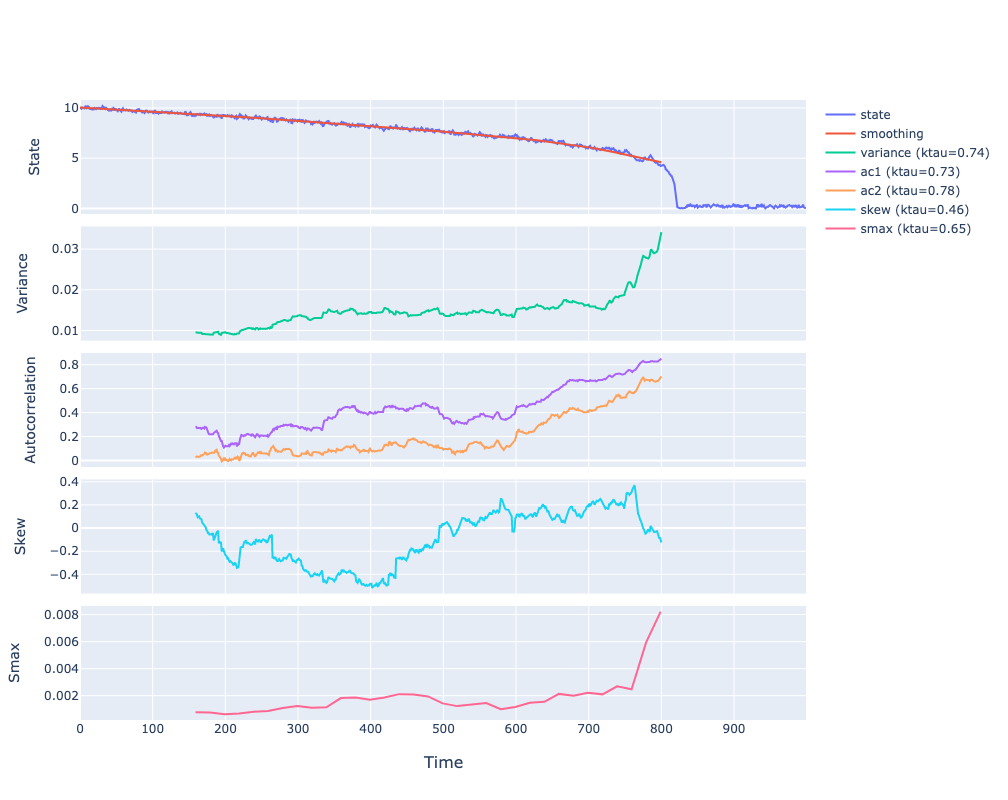

In [24]:
# Make quick plot of EWS
ts.make_plotly().update_layout(height=800)